In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('spx.xls', parse_dates=['date'], index_col='date')
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


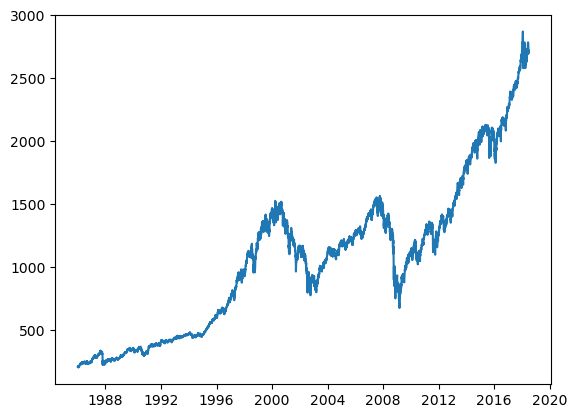

In [3]:
plt.plot(df)

In [4]:
train_size = int(len(df)*0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [5]:
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/var/folders/24/z61d72zx27z5ml8twybhwmm40000gn/T/ipykernel_17813/1140151302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
/var/folders/24/z61d72zx27z5ml8twybhwmm40000gn/T/ipykernel_17813/1140151302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [6]:
def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [7]:
TIME_STEPS = 30
X_train, y_train = create_seq(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_seq(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                               

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 [==============================] - 4s 14ms/step - loss: 0.1837 - val_loss: 0.2534
Epoch 2/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1079 - val_loss: 0.2041
Epoch 3/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1058 - val_loss: 0.2076
Epoch 4/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1111 - val_loss: 0.1329
Epoch 5/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1287 - val_loss: 0.2307
Epoch 6/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1157 - val_loss: 0.2531
Epoch 7/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1099 - val_loss: 0.3263
Epoch 8/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1321 - val_loss: 0.1601
Epoch 9/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1248 - val_loss: 0.2123
Epoch 10/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1506 - val_lo

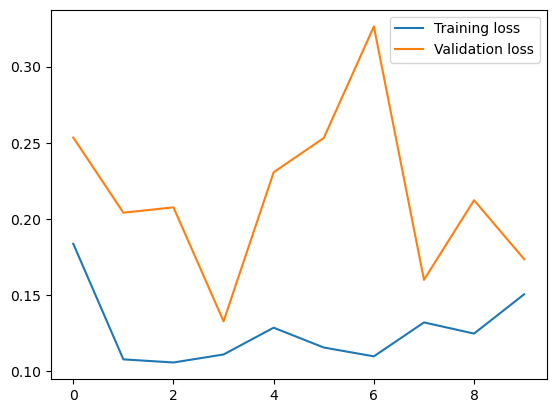

In [11]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

In [12]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 4ms/step - loss: 0.6696


0.6696313619613647

In [13]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 1s 4ms/step


/var/folders/24/z61d72zx27z5ml8twybhwmm40000gn/T/ipykernel_17813/4276719448.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True)


<Axes: ylabel='Density'>

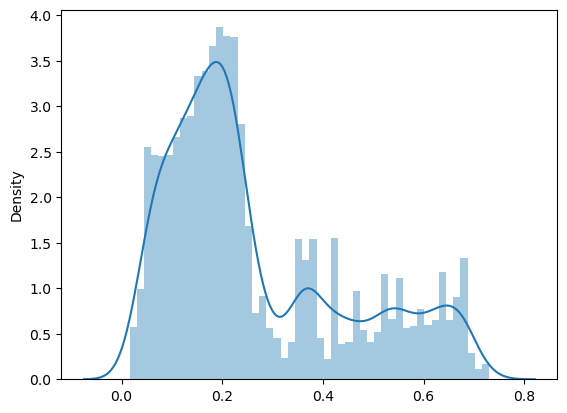

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [19]:
TRESHOLD = 0.9
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

12/12 [==============================] - 0s 4ms/step


In [20]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = TRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

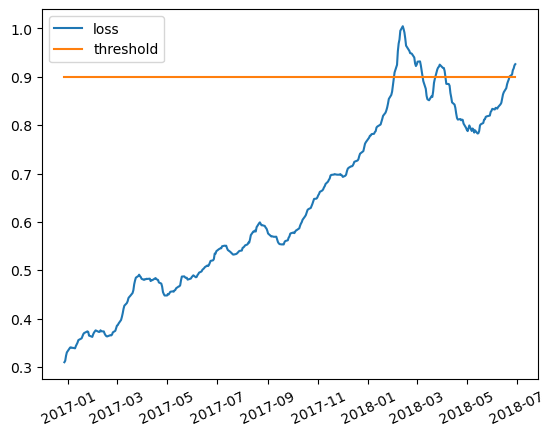

In [21]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [22]:
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-02,0.908979,0.9,True,3.319282
2018-02-05,0.924850,0.9,True,3.106679
2018-02-06,0.953071,0.9,True,3.193456
2018-02-07,0.969056,0.9,True,3.168136
2018-02-08,0.977247,0.9,True,2.979068


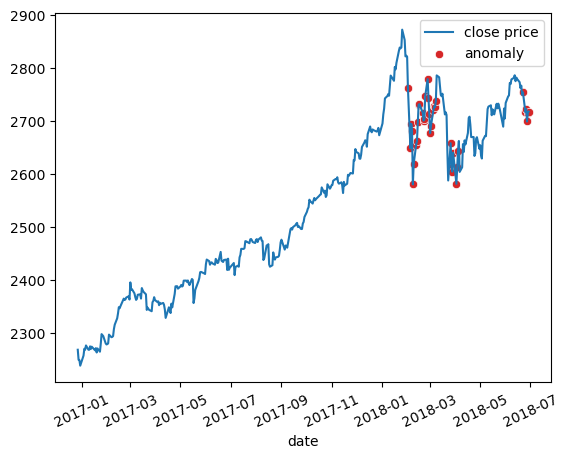

In [23]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array
anomalies_close = scaler.inverse_transform(anomalies_close)

plt.plot(test[TIME_STEPS:].index, 
         scaler.inverse_transform(test[TIME_STEPS:][["close"]]), 
         label='close price')
anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index, 
                y=anomalies_close, 
                color=sns.color_palette()[3], 
                label='anomaly'
               )

plt.xticks(rotation=25) 
plt.legend()
plt.show()